<a href="https://colab.research.google.com/github/janimiyarj/Time-Series-Analysis/blob/main/Time_Series_Analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from prophet import Prophet
from itertools import product


In [3]:
pip uninstall fbprophet


In [1]:
pip install prophet

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
df.head()
df.columns = ['Temperature']




In [4]:
df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


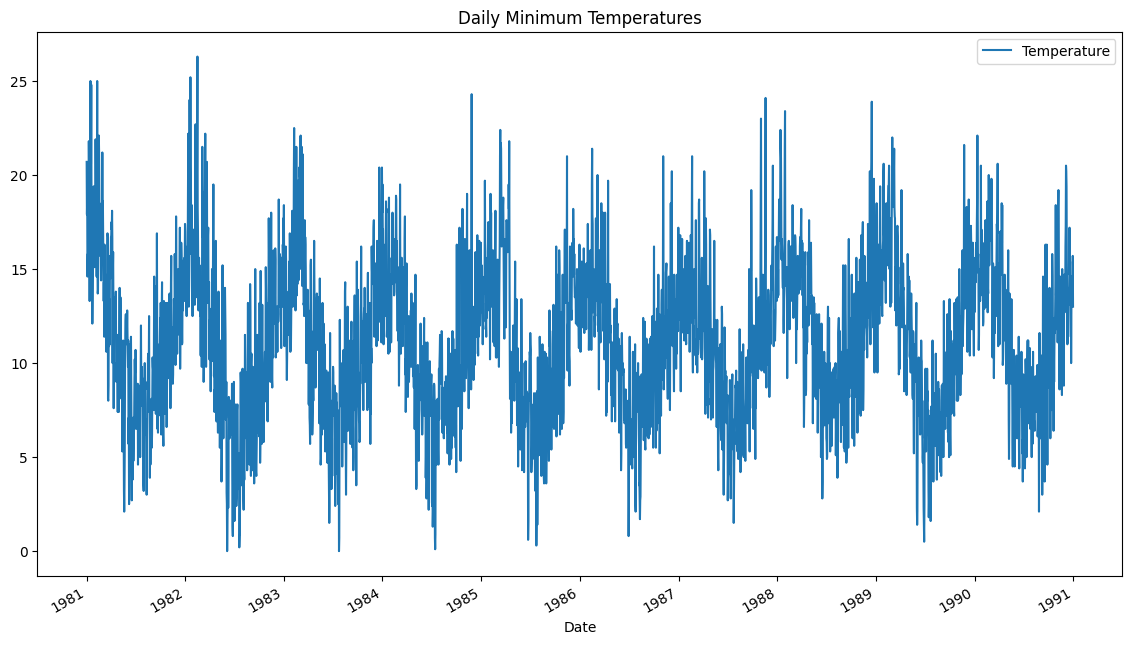

In [5]:
# Plot the time series
df.plot(figsize=(14,8))
plt.title('Daily Minimum Temperatures')
plt.show()

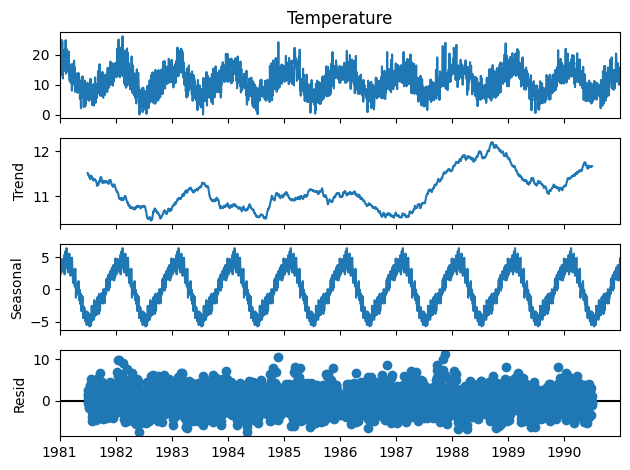

In [6]:
# Decomposition
decomposition = seasonal_decompose(df['Temperature'], model='additive', period=365)     #Can change these parameters to understand more better
decomposition.plot()
plt.show()

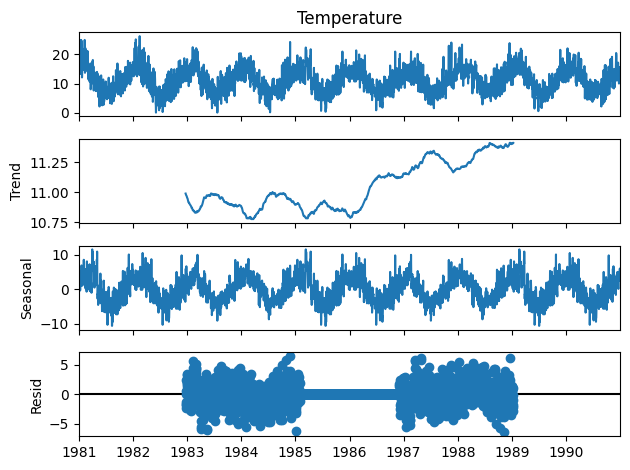

In [7]:
# Decomposition
decomposition2 = seasonal_decompose(df['Temperature'], model='additive', period=1440)
decomposition2.plot()
plt.show()

Yearly seasonality:

Daily data: period=365
Monthly data: period=12
Quarterly data: period=4
Weekly seasonality:

Daily data: period=7
Daily seasonality:

Hourly data: period=24
Minute data: period=1440

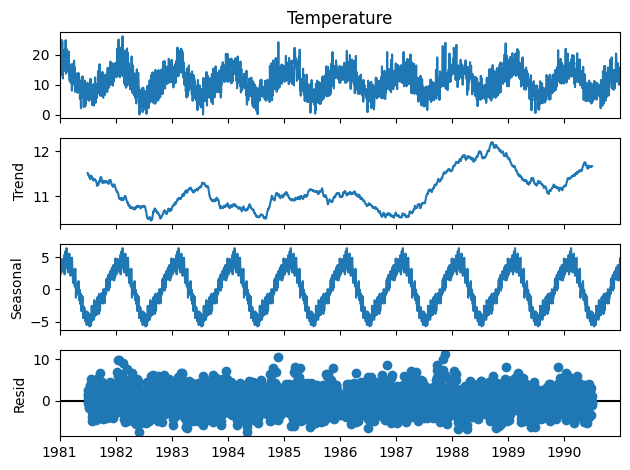

In [8]:
# Decomposition
decomposition2 = seasonal_decompose(df['Temperature'], model='Multiplicative', period=365)
decomposition2.plot()
plt.show()

In [9]:
# Stationarity test
adf_test = adfuller(df['Temperature'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -4.4448049246117
p-value: 0.0002470826300360994


Since my p-value is less than 0.05, I reject the Null Hypothesis, which means my Data is already Stationary. So no need to do the Difference. But if my p-value is greater than 0.05 then means it is Non-Stationary and we need to perform the Difference.

# Custom lag differencing
lag = 7  # For weekly differencing in daily data

df['Temp_lag_diff'] = df['Temperature'].diff(lag).dropna()

# Log differencing
df['Temp_log'] = np.log(df['Temperature'])

df['Temp_log_diff'] = df['Temp_log'].diff().dropna()

# Percentage change
df['Temp_pct_change'] = df['Temperature'].pct_change().dropna()


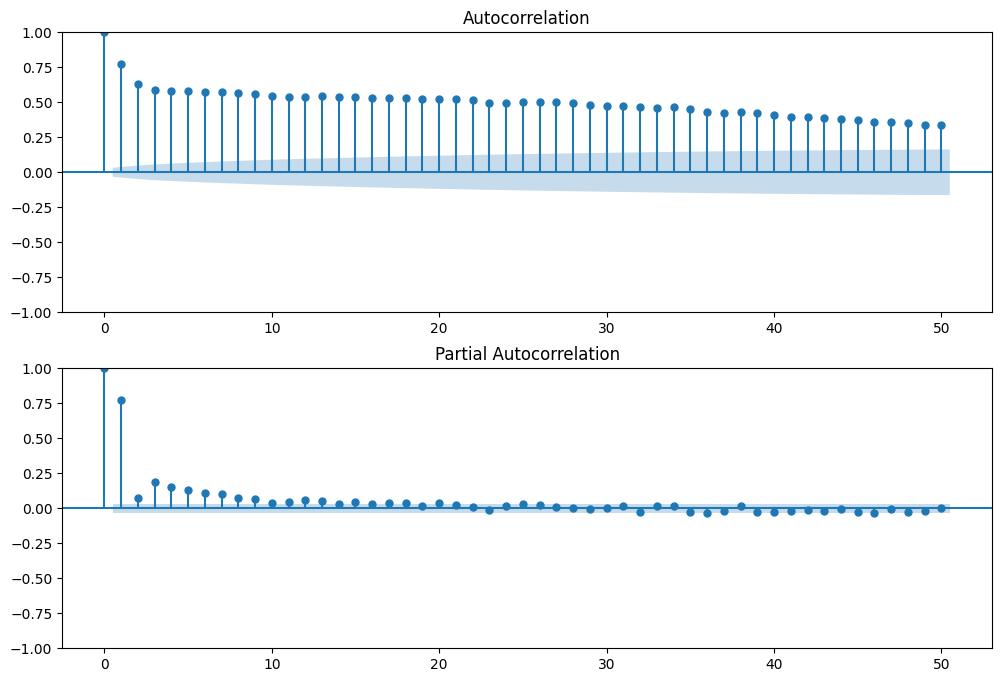

In [10]:
# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Temperature'], lags=50, ax=axes[0])
plot_pacf(df['Temperature'], lags=50, ax=axes[1])
plt.show()


In [11]:
# Function to fit ARIMA model
def arima_grid_search(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        print(f'Trying ARIMA{p,d,q}')
        try:
            model = ARIMA(data, order=(p,d,q))
            model_fit = model.fit()
            rmse = np.sqrt(mean_squared_error(data, model_fit.fittedvalues))
            if rmse < best_score:
                best_score, best_cfg = rmse, (p,d,q)
                print(f'New best ARIMA{best_cfg} RMSE={best_score}')
        except:
            continue
    print(f'Best ARIMA{best_cfg} RMSE={best_score}')
    return best_cfg

In [12]:

# Grid search for p, d, q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

In [13]:
best_order = arima_grid_search(df['Temperature'], p_values, d_values, q_values)

Trying ARIMA(0, 0, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


New best ARIMA(0, 0, 0) RMSE=4.071279075313714
Trying ARIMA(0, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


New best ARIMA(0, 0, 1) RMSE=3.0717389403593174
Trying ARIMA(0, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


New best ARIMA(0, 0, 2) RMSE=2.826751172641446
Trying ARIMA(0, 1, 0)
New best ARIMA(0, 1, 0) RMSE=2.752235455043772
Trying ARIMA(0, 1, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


New best ARIMA(0, 1, 1) RMSE=2.634389040641202
Trying ARIMA(0, 1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


New best ARIMA(0, 1, 2) RMSE=2.4473488598394395
Trying ARIMA(1, 0, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


New best ARIMA(1, 0, 2) RMSE=2.421638156729264
Trying ARIMA(1, 1, 0)
Trying ARIMA(1, 1, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(1, 1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2, 0, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Trying ARIMA(2, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


New best ARIMA(2, 0, 2) RMSE=2.4093662607875745
Trying ARIMA(2, 1, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2, 1, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Trying ARIMA(2, 1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA(2, 0, 2) RMSE=2.4093662607875745


In [14]:
print(best_order)

(2, 0, 2)


In [15]:
model = ARIMA(df['Temperature'], order=best_order)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [16]:
model

In [17]:
model_fit

<Axes: xlabel='Date'>

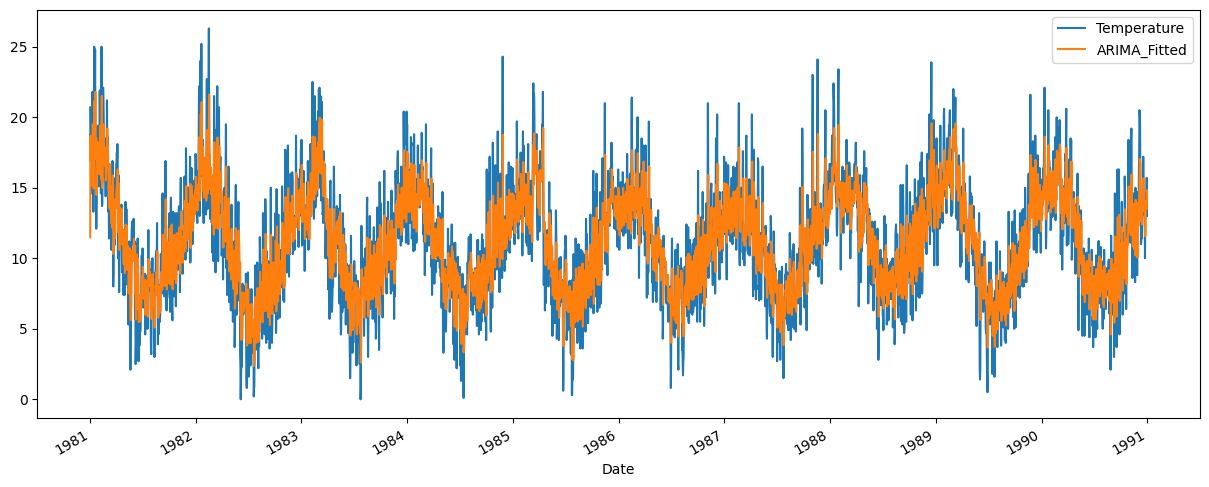

In [18]:
df['ARIMA_Fitted'] = model_fit.fittedvalues
df[['Temperature', 'ARIMA_Fitted']].plot(figsize=(15,6))

In [19]:
df.head()

,Temperature,ARIMA_Fitted
Date,,
1981-01-01,20.7,11.483910
1981-01-02,17.9,18.697396
1981-01-03,18.8,16.886408
1981-01-04,14.6,18.097364
1981-01-05,15.8,15.177624


In [20]:
# SARIMA Model with seasonal_order
def sarima_grid_search(data, p_values, d_values, q_values, P_values, D_values, Q_values, S):
    best_score, best_cfg = float("inf"), None
    for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
        try:
            model = SARIMAX(data, order=(p,d,q), seasonal_order=(P,D,Q,S))
            model_fit = model.fit(disp=False)
            rmse = np.sqrt(mean_squared_error(data, model_fit.fittedvalues))
            if rmse < best_score:
                best_score, best_cfg = rmse, (p,d,q,P,D,Q,S)
        except:
            continue
    print(f'Best SARIMA{best_cfg} RMSE={best_score}')
    return best_cfg

In [21]:
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
S = 12  # Monthly seasonality

In [ ]:
best_sarima_order = sarima_grid_search(df['Temperature'], p_values, d_values, q_values, P_values, D_values, Q_values, S)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
best_sarima_order = (1, 1, 1, 1, 1, 1, 12)        # Assumed as the above code is longer time

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<Axes: xlabel='Date'>

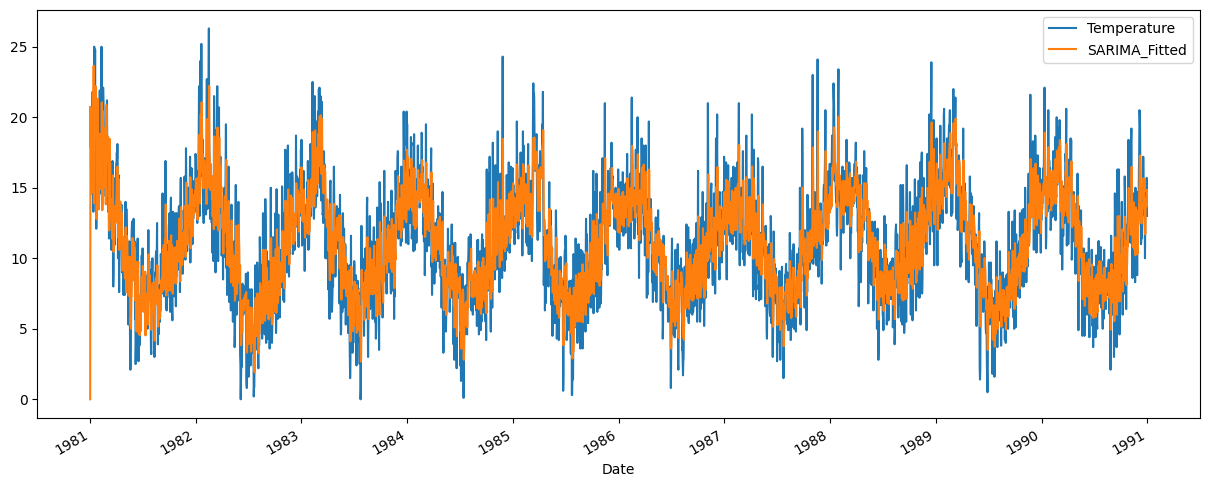

In [24]:
model = SARIMAX(df['Temperature'], order=best_sarima_order[:3], seasonal_order=best_sarima_order[3:])
model_fit = model.fit()
df['SARIMA_Fitted'] = model_fit.fittedvalues
df[['Temperature', 'SARIMA_Fitted']].plot(figsize=(15,6))

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Temperature']])

In [27]:
scaler

MinMaxScaler()

In [28]:
scaled_data

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       ...,
       [0.51330798],
       [0.59695817],
       [0.49429658]])

In [30]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

In [31]:
time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

In [33]:
print(X.shape)
print(y.shape)

(3620, 30, 1)
(3620, 1)


In [34]:
X

array([[[0.78707224],
        [0.68060837],
        [0.7148289 ],
        ...,
        [0.6539924 ],
        [0.58935361],
        [0.57414449]],

       [[0.68060837],
        [0.7148289 ],
        [0.55513308],
        ...,
        [0.58935361],
        [0.57414449],
        [0.58555133]],

       [[0.7148289 ],
        [0.55513308],
        [0.60076046],
        ...,
        [0.57414449],
        [0.58555133],
        [0.58174905]],

       ...,

       [[0.55893536],
        [0.48288973],
        [0.50570342],
        ...,
        [0.55513308],
        [0.53231939],
        [0.51711027]],

       [[0.48288973],
        [0.50570342],
        [0.50190114],
        ...,
        [0.53231939],
        [0.51711027],
        [0.51330798]],

       [[0.50570342],
        [0.50190114],
        [0.61596958],
        ...,
        [0.51711027],
        [0.51330798],
        [0.59695817]]])

In [35]:
y

array([[0.58555133],
       [0.58174905],
       [0.7148289 ],
       ...,
       [0.51330798],
       [0.59695817],
       [0.49429658]])

In [36]:
X.shape[0]

3620

In [37]:
X.shape[1]

30

In [38]:
# Reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [39]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0537 - val_loss: 0.0102
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0123 - val_loss: 0.0102
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0115 - val_loss: 0.0101
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0115 - val_loss: 0.0102
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0128 - val_loss: 0.0099
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0119 - val_loss: 0.0103
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0115 - val_loss: 0.0097
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0113 - val_loss: 0.0090
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0101 - val_loss: 0.0086
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.

In [50]:
predicted_lstm = model.predict(X)

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [51]:
predicted_lstm

array([[0.5916349],
       [0.5958942],
       [0.5864702],
       ...,
       [0.5005703],
       [0.5005552],
       [0.5526588]], dtype=float32)

In [52]:
print(f'Length of predicted_lstm: {len(predicted_lstm)}')
print(f'Length of df: {len(df)}')


Length of predicted_lstm: 3620
Length of df: 3650


In [53]:
predicted_df = pd.DataFrame(predicted_lstm, columns=['LSTM_Fitted'])

In [54]:
predicted_df.index = df.index[-len(predicted_lstm):]

# Now you can join this DataFrame with the original DataFrame
df = df.join(predicted_df, how='left')

<Axes: xlabel='Date'>

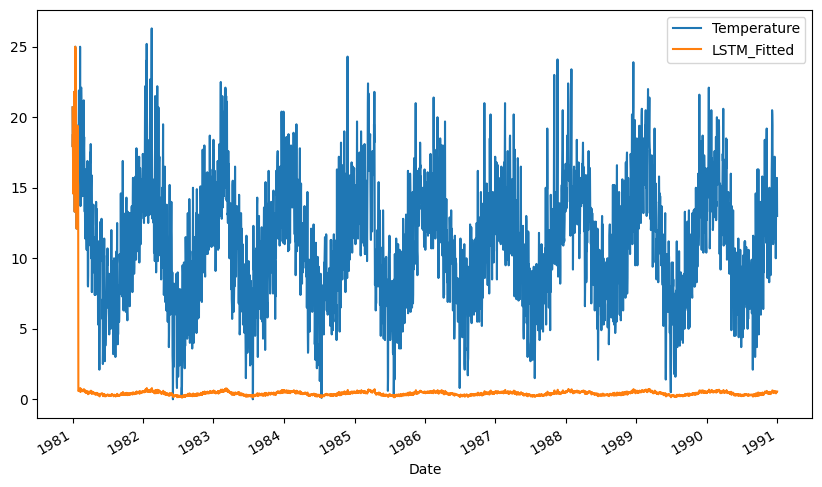

In [68]:
df[['Temperature', 'LSTM_Fitted']].plot(figsize=(10,6))

In [59]:
df.tail(10)

,Temperature,ARIMA_Fitted,SARIMA_Fitted,LSTM_Fitted
Date,,,,
1990-12-22,13.2,13.301456,13.548085,0.492569
1990-12-23,13.9,13.676239,13.549985,0.506924
1990-12-24,10.0,13.934939,13.828401,0.521520
1990-12-25,12.9,11.552687,11.698383,0.422807
1990-12-26,14.6,13.631775,13.453419,0.507925
1990-12-27,14.0,14.058465,14.245039,0.527924
1990-12-28,13.6,13.655205,13.833873,0.504144
1990-12-29,13.5,13.540494,13.685580,0.500570
1990-12-30,15.7,13.503426,13.661362,0.500555


In [60]:
# Optionally fill NaN values with the original temperature values if needed
df['LSTM_Fitted'].fillna(df['Temperature'], inplace=True)

<ipython-input-60-0ed3655aa871>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LSTM_Fitted'].fillna(df['Temperature'], inplace=True)
<ipython-input-60-0ed3655aa871>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5
 25.  20.7 20.6 24.8 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2
 15.5 15.1]' has dtype incompatible with float32, please explicitly cast to a compatibl

In [61]:
df.head()

,Temperature,ARIMA_Fitted,SARIMA_Fitted,LSTM_Fitted
Date,,,,
1981-01-01,20.7,11.483910,0.000000,20.7
1981-01-02,17.9,18.697396,20.699959,17.9
1981-01-03,18.8,16.886408,17.899992,18.8
1981-01-04,14.6,18.097364,18.799993,14.6
1981-01-05,15.8,15.177624,14.600013,15.8


In [62]:
# Prepare data for Prophet
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Temperature': 'y'})

In [64]:
df_prophet.head()

,ds,y,ARIMA_Fitted,SARIMA_Fitted,LSTM_Fitted
0,1981-01-01,20.7,11.483910,0.000000,20.7
1,1981-01-02,17.9,18.697396,20.699959,17.9
2,1981-01-03,18.8,16.886408,17.899992,18.8
3,1981-01-04,14.6,18.097364,18.799993,14.6
4,1981-01-05,15.8,15.177624,14.600013,15.8


In [63]:
prophet_model = Prophet()
prophet_model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7fxoyepp/10lc5y9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7fxoyepp/x7wj6at1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93294', 'data', 'file=/tmp/tmp7fxoyepp/10lc5y9n.json', 'init=/tmp/tmp7fxoyepp/x7wj6at1.json', 'output', 'file=/tmp/tmp7fxoyepp/prophet_modelx65ydr3x/prophet_model-20241015012221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [73]:
prophet_model

In [66]:
future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future)

In [69]:
future

,ds
0,1981-01-01
1,1981-01-02
2,1981-01-03
3,1981-01-04
4,1981-01-05
...,...
4010,1991-12-27
4011,1991-12-28
4012,1991-12-29
4013,1991-12-30


In [70]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1981-01-01,11.845441,11.811188,18.306041,11.845441,11.845441,3.328357,3.328357,3.328357,0.010971,0.010971,0.010971,3.317386,3.317386,3.317386,0.0,0.0,0.0,15.173798
1,1981-01-02,11.843590,11.715283,18.669929,11.843590,11.843590,3.375348,3.375348,3.375348,-0.019836,-0.019836,-0.019836,3.395184,3.395184,3.395184,0.0,0.0,0.0,15.218939
2,1981-01-03,11.841740,11.803184,18.647742,11.841740,11.841740,3.412345,3.412345,3.412345,-0.060155,-0.060155,-0.060155,3.472501,3.472501,3.472501,0.0,0.0,0.0,15.254085
3,1981-01-04,11.839889,11.727852,18.509134,11.839889,11.839889,3.394984,3.394984,3.394984,-0.153103,-0.153103,-0.153103,3.548087,3.548087,3.548087,0.0,0.0,0.0,15.234873
4,1981-01-05,11.838038,11.975617,19.055115,11.838038,11.838038,3.600999,3.600999,3.600999,-0.019721,-0.019721,-0.019721,3.620720,3.620720,3.620720,0.0,0.0,0.0,15.439037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,1991-12-27,11.628702,10.981715,17.937904,11.548350,11.710713,2.898748,2.898748,2.898748,-0.019836,-0.019836,-0.019836,2.918584,2.918584,2.918584,0.0,0.0,0.0,14.527450
4011,1991-12-28,11.628774,11.271566,17.783941,11.548215,11.711033,2.917292,2.917292,2.917292,-0.060155,-0.060155,-0.060155,2.977447,2.977447,2.977447,0.0,0.0,0.0,14.546066
4012,1991-12-29,11.628846,10.743595,17.754080,11.547992,11.711400,2.888691,2.888691,2.888691,-0.153103,-0.153103,-0.153103,3.041794,3.041794,3.041794,0.0,0.0,0.0,14.517537
4013,1991-12-30,11.628918,11.037745,18.362374,11.547687,11.711827,3.091150,3.091150,3.091150,-0.019721,-0.019721,-0.019721,3.110871,3.110871,3.110871,0.0,0.0,0.0,14.720068


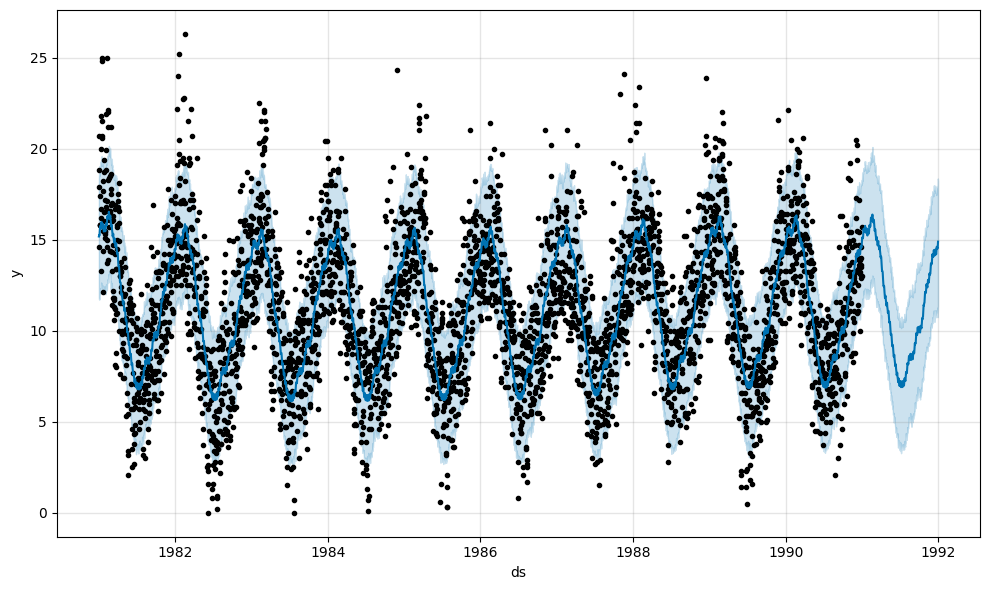

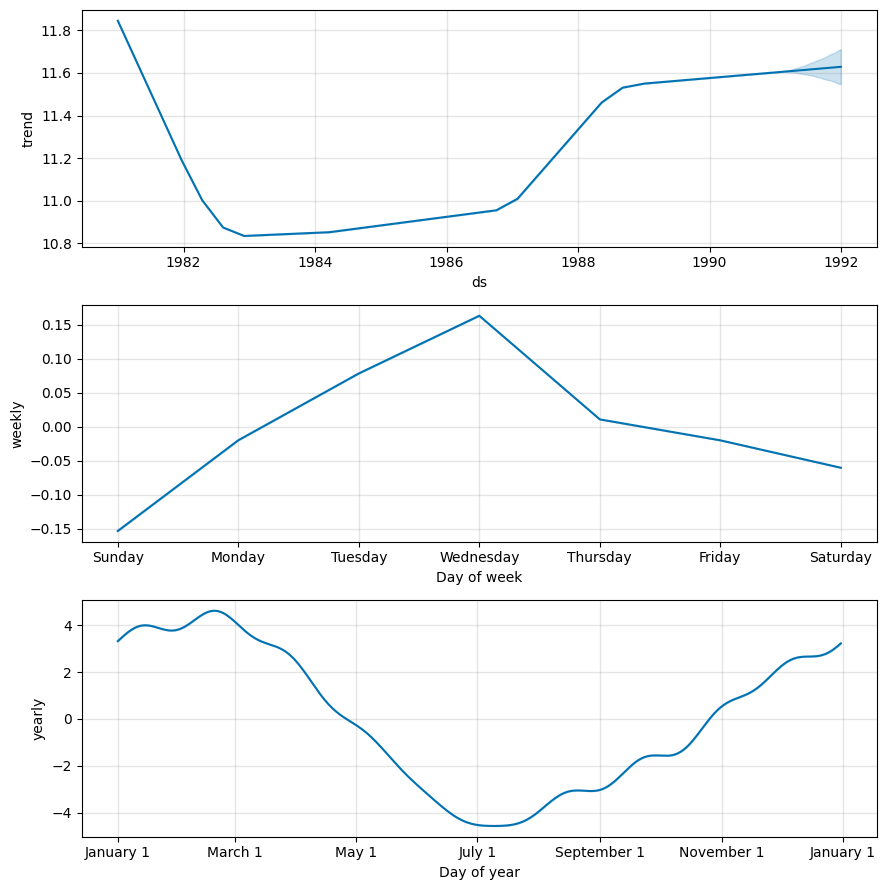

In [67]:
prophet_model.plot(forecast)
prophet_model.plot_components(forecast)
plt.show()